In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

## Exercise 2, part 2

We build a CNN where both the input and the output are images (dogs vs cats) https://www.kaggle.com/c/dogs-vs-cats

Goal: The dataloader adds random noise to the image, and the network task is to remove that noise, recovering the original image.

In [ ]:
!unzip ../../Datasets/cats.npy.zip

In [ ]:
%load_ext autoreload
%autoreload 2

### Dataloader

You don't need to write it, just look at it. For every picture of a cat, it adds a random noise to it.

In [2]:
from cats_dataloader import CatsWithNoiseDataset

In [43]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
import glob
from skimage.draw import random_shapes

class CatsWithNoiseDataset(Dataset):
    def __init__(self, path,start_idx=0, end_idx=-1):
        
        self.data = np.load(path)
        self.data = self.data[start_idx:end_idx]

    def __len__(self):
       
        return len(self.data)
    
    def add_noise(self,y):
        newimg = random_shapes((256, 256),num_channels = 1,min_shapes=30,max_shapes=42,
                         min_size=20,max_size=30,allow_overlap=True)[0]/255.0
        # Assuming your array is named 'image'
        newimg = np.reshape(newimg, (256, 256))
        x = y.copy()
        x[np.where(newimg < 0.9)] = x[np.where(newimg < 0.9)]+1-newimg[newimg < 0.9]
        return x

    def __getitem__(self, idx):
        
        y = self.data[idx]

        x = torch.FloatTensor(self.add_noise(y)).unsqueeze(0)
        
        return x, torch.FloatTensor(y).unsqueeze(0)

In [44]:
# I divide 80% of images to be our training set and 20% our validation set

train_ds = CatsWithNoiseDataset('cats.npy',0,800)
valid_ds = CatsWithNoiseDataset('cats.npy',800,1000)

In [38]:
valid_ds

In [33]:
len(train_ds)

800

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


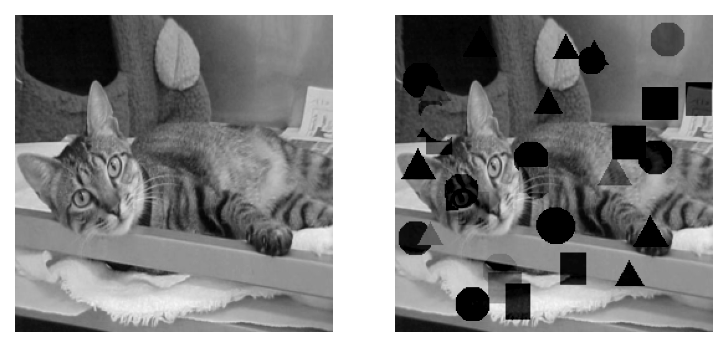

In [45]:
x, y = train_ds[100]
print(x.shape,y.shape)

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [46]:
# batch_size = 4, memory problem otherwise (but play around with it)

training_dataloader = DataLoader(train_ds,batch_size=4,shuffle=True)
valid_dataloader = DataLoader(valid_ds,batch_size=20)

In [47]:
for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


### The model

In [49]:
# Conv2d(input channel, output channel, convolutional filter size)
# padding needs to be tuned in a way that output and input coincide

conv_layer = nn.Conv2d(1,50,3,padding = 1)

print(x.shape, conv_layer(x).shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 50, 256, 256])


In [ ]:
# BatchNorm2d It takes as input a batch with shape (N, input_size) 
# and normalizes each "column" in the input batch to have 
# mean 0 and variance 1.

We need to build a model that takes the images as input and outputs an image of the same size.

You can find an example of a model that works below (you can try to build your own). I repeated each block 5 times. Blue boxes correspond to the sequence.

* Conv2d
* BatchNorm2d
* ReLU

<div>
<img src="model_example.jpeg" width="600"/>
</div>

In this way the model will learn the negative value of the noise. Thefore the output will be the sum of the input and the result of the model (a residual block).

In [1]:
from model_denoise import Net

In [2]:
# Argument indicates number of central layer blocks (5)
# output size 25 central layers

net = Net()

print(net)

Net(
  (layer1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): ReLU(inplace=True)
  (central_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (last_layer): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [3]:
# Make sure the output is same size of the input..!!!

x.shape, net(x).shape

NameError: name 'x' is not defined

## Training and validation

In [63]:
# The error is MSE, mean square error. We are regressing the correct pixel.

loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

In [64]:
def compute_loss(dataloader,net):

    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            pred = net(x)
            
            loss+= loss_func(pred,y).item()
            
    loss = loss/n_batches      
    return loss

In [65]:
# Before training
compute_loss(valid_dataloader,net)

0.09289172291755676

In [71]:
# It takes some time... in the mean time read about google colab, for next exercises we could start CUDA from there

if os.path.exists('trained_model.pt'):
    net.load_state_dict(torch.load('trained_model.pt',map_location='cpu'))
else:
    n_epochs = 20

    validation_loss_vs_epoch = []

    if torch.cuda.is_available():
        net.cuda()

    pbar = tqdm( range(n_epochs) )

    for epoch in pbar:

        if len(validation_loss_vs_epoch) > 1:
            print('epoch',epoch,' val loss:'+'{0:.5f}'.format(validation_loss_vs_epoch[-1]) )

        net.train() # put the net into "training mode"
        for x,y in training_dataloader:
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()

            optimizer.zero_grad()
            pred = net(x)
            loss = loss_func(pred,y)
            loss.backward()
            optimizer.step()

        net.eval() #put the net into evaluation mode

        valid_loss =  compute_loss(valid_dataloader,net)

        validation_loss_vs_epoch.append(valid_loss)

        if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
            torch.save(net.state_dict(), 'trained_model.pt')

### Continuing Training

In [72]:
n_epochs = 20


if torch.cuda.is_available():
    net.cuda()

pbar = tqdm( range(n_epochs) )

for epoch in pbar:

    if len(validation_loss_vs_epoch) > 1:
        print('epoch',epoch,' val loss:'+'{0:.5f}'.format(validation_loss_vs_epoch[-1]) )

    net.train() # put the net into "training mode"
    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        optimizer.zero_grad()
        pred = net(x)
        loss = loss_func(pred,y)
        loss.backward()
        optimizer.step()

    net.eval() #put the net into evaluation mode

    valid_loss =  compute_loss(valid_dataloader,net)

    validation_loss_vs_epoch.append(valid_loss)

    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0  val loss:0.00863
epoch 1  val loss:0.00856
epoch 2  val loss:0.00844
epoch 3  val loss:0.00821
epoch 4  val loss:0.00958
epoch 5  val loss:0.00846
epoch 6  val loss:0.00777
epoch 7  val loss:0.00764
epoch 8  val loss:0.00767
epoch 9  val loss:0.00772
epoch 10  val loss:0.01134
epoch 11  val loss:0.00776
epoch 12  val loss:0.00776
epoch 13  val loss:0.00772
epoch 14  val loss:0.00752
epoch 15  val loss:0.00737
epoch 16  val loss:0.00703
epoch 17  val loss:0.00772
epoch 18  val loss:0.00833
epoch 19  val loss:0.00702


In [73]:
# After training
compute_loss(valid_dataloader,net)

0.0076036076992750164

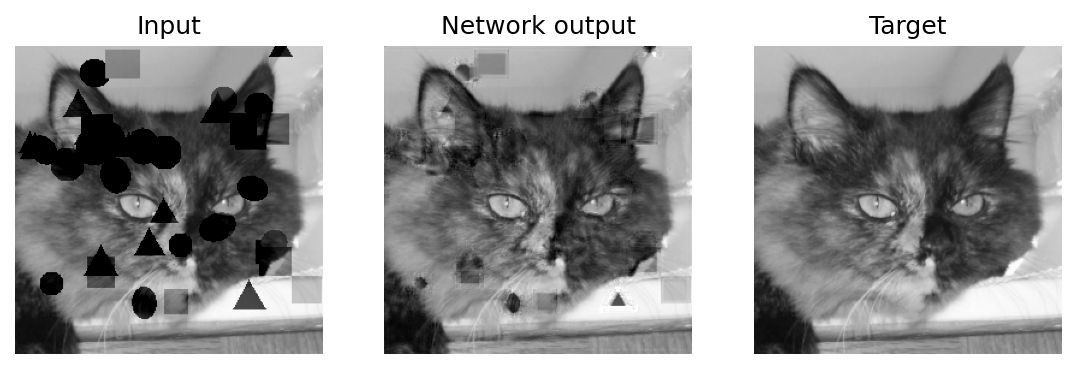

In [81]:
# Check the result with a random validation idx
x, y = valid_ds[103]

fig,ax = plt.subplots(1,3,figsize=(9,3),dpi=150)

ax[2].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[0].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

net.eval()
net.cpu()
predicted = net( x.unsqueeze(1) )[0][0].data.numpy()

ax[1].imshow(predicted,cmap='gist_yarg',vmin=0,vmax=1)

ax[0].set_title('Input',fontsize=12)
ax[1].set_title('Network output',fontsize=12)
ax[2].set_title('Target',fontsize=12)
for i in range(3):
    ax[i].set_axis_off()

plt.show()